# Digital Music Store Analysis

This project will analyze the Chinook playlist database by Udacity. We will examine the dataset with SQL and help the store understand its business growth by answering simple questions like:
1. What are the top genres sold?

2. Which city has the best customers?  
a. How many songs did they buy?  
b. How much in sales was generated?

3. The highest number of invoices belogs to which country?

4. The company would ike to put on a rock concert but would like to know:  
a. Which location should host the concert?  
b. Which artist should be invited?  
c. Generate a list of contact information for customers to invite.  
d. Find the top selling employee to give a ticket.

Dataset: Here is an image that describes the information contained in the database.
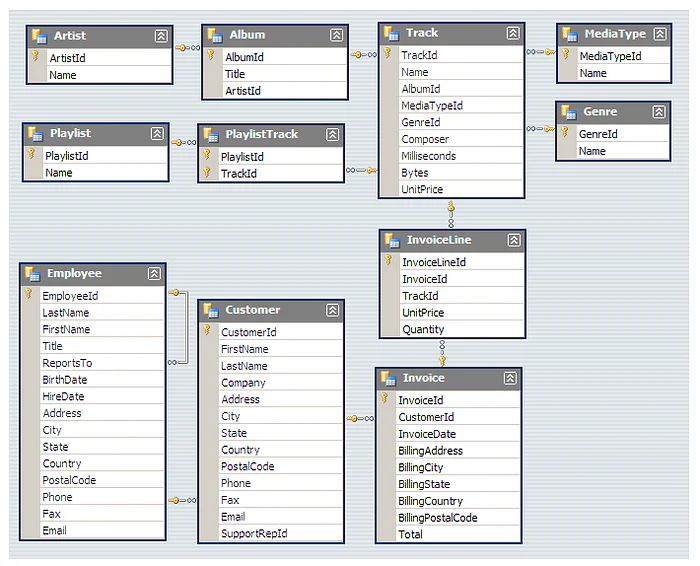


The hidden code is for setting up the connection to the database.

In [2]:
#@title
# Imports
import sqlite3 as sq3
import pandas.io.sql as pds
import pandas as pd

In [3]:
#@title
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
#@title
# Create a variable, `path`, containing the path to the `chinook.db``
path = '/content/drive/MyDrive/Colab Notebooks/chinook.db'

In [6]:
#@title
# Create a connection, `con`, that is connected to database at `path`
con = sq3.Connection(path)

First let's take a look at the names of all the tables in the database.

In [7]:
#@title

# Create a variable, tables, which reads in all data from the table sqlite_master
tables = """

SELECT name AS Table_Names FROM sqlite_master WHERE type='table'

"""
observations = pd.read_sql(tables, con)
print(observations)

       Table_Names
0            album
1           artist
2         customer
3         employee
4            genre
5          invoice
6     invoice_line
7       media_type
8         playlist
9   playlist_track
10           track


## 1. What is the top genre sold?

In [92]:
Query = """

SELECT 
    genre.name AS genre,
    COUNT(invoice_line.quantity) AS total_sold
FROM invoice_line
INNER JOIN track ON invoice_line.track_id = track.track_id
INNER JOIN genre ON track.genre_id = genre.genre_id
    GROUP BY genre
    ORDER BY total_sold DESC
LIMIT 1
"""
observations = pd.read_sql(Query, con)
print(observations)

  genre  total_sold
0  Rock        2635


### Results
The Rock genre has sold more tracks than any other genre. Infact the number of tracks sold in the Rock genre sold 4.26 time more tracks than the next highest genre, which is Metal

## 2. Which city has the best customers?  
### a. How many songs did they buy?  
### b. How much in sales was generated?

In [94]:
Query = """

SELECT 
    billing_city AS city,
    billing_country AS country,
    SUM(total) AS total_amount_sold,
    SUM(total)/.99 AS total_songs_sold
FROM 
    invoice
GROUP BY city
ORDER BY total_amount_sold DESC
limit 1

"""
observations = pd.read_sql(Query, con)
observations

,city,country,total_amount_sold,total_songs_sold
0,Prague,Czech Republic,273.24,276.0


### Results  
Prague, Czech Republic is the city with the most sales. Customers in Prague bought 276 songs totaling $273.24 in sales.

## 3. The highest number of invoices belogs to which country?

In [14]:
Query = """

SELECT 
    billing_country AS country,
    COUNT(billing_country) AS invoice_count,
    SUM(total) AS total_purchased
FROM 
    invoice
    GROUP BY country
ORDER BY invoice_count DESC
LIMIT 1

"""
observations = pd.read_sql(Query, con)
print(observations)

  country  invoice_count  total_purchased
0     USA            131          1040.49


### Result  
When the entire country is looked at collectively, the USA has the highest sales of any other country with a total of $1,040.49

## 4. The company would ike to put on a rock concert but would like to know:

a. Which location should host the concert?  
b. Which artist should be invited?  
c. Generate a list of contact information for customers to invite.  
d. Find the top selling employee to give a ticket.

In [95]:
# Find the city with the most rock-music listeners.
Query = """

SELECT 
    billing_city AS city,
    COUNT(invoice_line_id) AS num
FROM invoice
INNER JOIN invoice_line
    ON invoice.invoice_id = invoice_line.invoice_id
INNER JOIN track
    ON track.track_id = invoice_line.track_id
WHERE track.genre_id = 1
GROUP BY city
ORDER BY num DESC
LIMIT 1

"""
city_observations = pd.read_sql(Query, con)
print(city_observations)

     city  num
0  Prague  143


In [96]:
# Find artists with the most songs.
Query = """

SELECT 
    artist.name As artist,
    COUNT(artist.artist_id) As number_of_tracks
FROM 
    track
INNER JOIN album ON track.album_id = album.album_id
INNER JOIN artist ON album.artist_id = artist.artist_id
INNER JOIN genre ON track.genre_id = genre.genre_id
    WHERE genre.name like 'Rock'
    GROUP BY artist
    ORDER BY number_of_tracks DESC

LIMIT 5

"""
artist_observations = pd.read_sql(Query, con)
artist_observations

,artist,number_of_tracks
0,Led Zeppelin,114
1,U2,112
2,Deep Purple,92
3,Iron Maiden,81
4,Pearl Jam,54


In [97]:
# Find the artist that has earned the company the most money.
Query = """

SELECT 
    artist.name AS artist,
    SUM(invoice_line.unit_price*invoice_line.quantity) AS total_sales
FROM invoice_line
INNER JOIN track ON track.track_id = invoice_line.track_id
INNER JOIN album ON album.album_id = track.album_id
INNER JOIN artist ON artist.artist_id = album.artist_id
INNER JOIN genre ON genre.genre_id = track.genre_id
    WHERE genre.name LIKE 'Rock'
    GROUP BY artist
    ORDER BY total_sales DESC
LIMIT 5

"""
top_selling_artist = pd.read_sql(Query, con)
top_selling_artist

,artist,total_sales
0,Queen,190.08
1,Jimi Hendrix,185.13
2,Nirvana,128.70
3,AC/DC,122.76
4,The Rolling Stones,115.83


In [101]:
# Find the top selling employees and send them to the concert.
Query = """

SELECT 
    employee.first_name AS first_name, employee.last_name AS last_name,
    SUM(invoice.total) AS total_sales
FROM 
    employee
INNER JOIN customer ON customer.support_rep_id = employee.employee_id
INNER JOIN invoice ON invoice.customer_id = customer.customer_id
    GROUP BY  employee.last_name
    ORDER BY total_sales DESC

"""
top_employees_observations = pd.read_sql(Query, con)
top_employees_observations

,first_name,last_name,total_sales
0,Jane,Peacock,1731.51
1,Margaret,Park,1584.00
2,Steve,Johnson,1393.92


### Conclusion:  
I would recommend hosting the rock concert in the city of Prague. It seems they love their rock music there. According to the number of songs each artist has written and the amout of sales each artist has generated for the company I think that Led Zepplin and Queen should be invited to play at the concert, but according to the figures Led Zepplin will be the opening act and Queen will be the headliner.  

Since Jane Peacock worked so hard generating $1731.51 in sales, she should be given a free ticket to the concert as a reward.  

The following is a list of all customers who have bought at least one song in the rock genre from the company. Send them an invite to purchase a ticket to the concert in Prague

In [100]:
# Generate a list of customers that listen to rock music to send invitations to the concert.
Query = """

SELECT 
    first_name, last_name,
    email,
    address, city, state, country, postal_code
FROM 
    customer
INNER JOIN invoice ON invoice.customer_id = customer.customer_id
INNER JOIN invoice_line ON invoice_line.invoice_id = invoice.invoice_id
INNER JOIN track ON track.track_id = invoice_line.track_id
INNER JOIN genre ON genre.genre_id = track.genre_id
    WHERE genre.name LIKE 'Rock'
    GROUP BY state
    ORDER BY last_name

"""
invite_list = pd.read_sql(Query, con)
invite_list

,first_name,last_name,email,address,city,state,country,postal_code
0,Roberto,Almeida,roberto.almeida@riotur.gov.br,"Praça Pio X, 119",Rio de Janeiro,RJ,Brazil,20040-020
1,Julia,Barnett,jubarnett@gmail.com,302 S 700 E,Salt Lake City,UT,USA,84102
2,Michelle,Brooks,michelleb@aol.com,627 Broadway,New York,NY,USA,10012-2612
3,Kathy,Chase,kachase@hotmail.com,801 W 4th Street,Reno,NV,USA,89503
4,Richard,Cunningham,ricunningham@hotmail.com,2211 W Berry Street,Fort Worth,TX,USA,76110
5,Edward,Francis,edfrancis@yachoo.ca,230 Elgin Street,Ottawa,ON,Canada,K2P 1L7
6,Luís,Gonçalves,luisg@embraer.com.br,"Av. Brigadeiro Faria Lima, 2170",São José dos Campos,SP,Brazil,12227-000
7,John,Gordon,johngordon22@yahoo.com,69 Salem Street,Boston,MA,USA,2113
8,Patrick,Gray,patrick.gray@aol.com,1033 N Park Ave,Tucson,AZ,USA,85719
9,Heather,Leacock,hleacock@gmail.com,120 S Orange Ave,Orlando,FL,USA,32801
